In [1]:
import numpy as np
from os.path import exists
from random import random
import matplotlib.pyplot as plt

In [2]:
STATE_COUNT=19683

EMPTY=0
CROSS=1
ZERO=2

WIN_COMBS=[[0, 1, 2], [0, 3, 6], [0, 4, 8], [1, 4, 7], [2, 4, 6], [2, 5, 8], [3, 4, 5], [6, 7, 8]]


def isDraw(state):
    return (np.count_nonzero(toArray(state)) == 9) and (not isWin(state, CROSS)) and (not isWin(state, ZERO))


def isWin(state, marker):
    cells = toArray(state)
    for win_comb in WIN_COMBS:
        if all(cells[i] == marker for i in win_comb):
            return True
    return False


def toArray(state):
    base_repr = np.base_repr(state, 3).rjust(9, '0')
    return np.array([int(cell) for cell in base_repr]).flatten()     


def toState(array):
    return int(sum(array[i]*(3**(8-i)) for i in range(9)))

In [3]:
class Agent:
    def __init__(self, marker, epsilon, alpha, value_path):
        self.marker = marker
        self.epsilon = epsilon
        self.alpha = alpha
        self.value_path = value_path
        self.init_values()
        self.state = EMPTY
    
    def init_values(self):
        if not exists(self.value_path):
            self.values = np.full(shape=STATE_COUNT, fill_value=0.5)
            for state in range(STATE_COUNT):
                if isWin(state, self.marker):
                    self.values[state] = 1
            self.values.tofile(self.value_path)
        else:
            self.values = np.fromfile(self.value_path)
    
    def next_state(self, curr_field, cell):
        next_field = curr_field.copy()
        next_field[cell] = self.marker
        return toState(next_field)
    
    def choice_place(self, prev_state):
        prev_field = toArray(prev_state)
        empty_cells = np.argwhere(prev_field == EMPTY).flatten()
        curr_state = -1
        
        if random() > self.epsilon:
            possible_states = np.array([self.next_state(prev_field, cell) for cell in empty_cells])
            possible_values = np.array([self.values[st] for st in possible_states])
            max_values = np.argwhere(possible_values == np.max(possible_values)).flatten()
            curr_state = possible_states[np.random.choice(max_values)]
        else:
            curr_state = self.next_state(prev_field, np.random.choice(empty_cells))
        
        self.values[self.state] += self.alpha*(self.values[curr_state] - self.values[self.state])
        self.state = curr_state
        return curr_state

    def reset(self):
        self.state = EMPTY
            
    def save_values(self):
        self.values.tofile(self.value_path)

In [4]:
class Game:
    def __init__(self, agent):
        self.agent_cross = Agent(CROSS, 0, 0, 'default.values') #необучающийся случайно действующий агент
        self.agent_zero = agent
        self.state = EMPTY
        self.gameEnded = False
        self.agent_wins = 0
    
    def reset(self):
        self.agent_cross.reset()
        self.agent_zero.reset()
        self.gameEnded = True
    
    def set_state(self, new_state):
        self.state = new_state
        
        if isWin(new_state, ZERO):
            self.reset()
            self.agent_wins += 1
        elif isWin(new_state, CROSS) or isDraw(new_state):
            self.reset()
    
    def play(self, batch_size, agent_stat):
        for _ in range(batch_size):
            self.gameEnded = False
            self.state = EMPTY
            while not self.gameEnded:
                move_cross = self.agent_cross.choice_place(self.state)
                self.set_state(move_cross)
                if not self.gameEnded:
                    move_zero = self.agent_zero.choice_place(self.state)
                    self.set_state(move_zero)
        
        agent_stat.append(self.agent_wins)
        self.agent_wins = 0
        self.agent_zero.save_values()
    
    def session(self, batch_count, batch_size):
        agent_stat = list()
        for _ in range(batch_count):
            self.play(batch_size, agent_stat)
            
        show_stats(agent_stat, batch_count, batch_size)

In [5]:
def show_stats(agent_stat, batch_count, batch_size):
    x = np.arange(batch_count)
    y = np.array(agent_stat)
    
    plt.figure(figsize=(16, 9))
    plt.xticks(x)
    plt.plot(x, y, color = 'red')
    
    plt.xlabel('Номер игровой сессии')
    plt.ylabel(f'Количество побед в сессии ({batch_size} игр)')
    plt.savefig('result.png')
    plt.show()

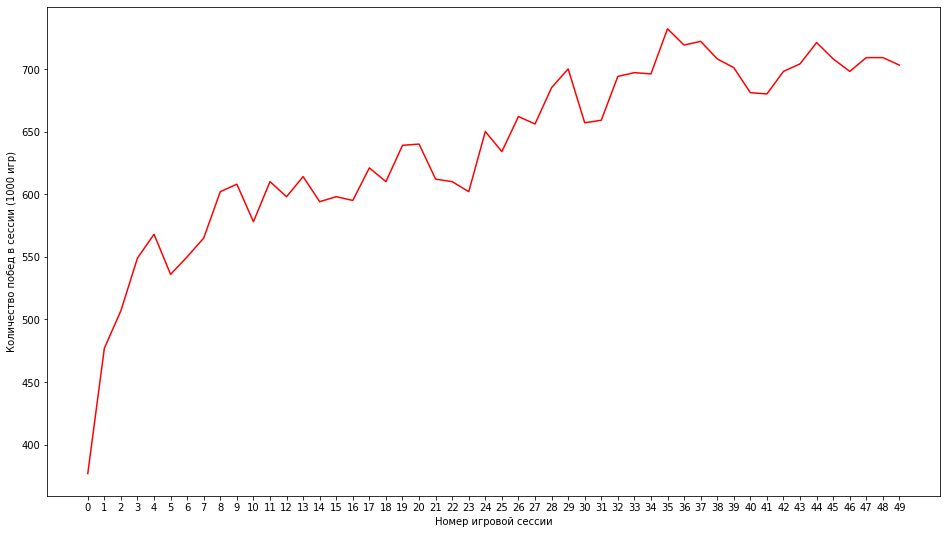

In [6]:
agent = Agent(ZERO, 0.2, 0.05, 'agent.values')
game = Game(agent)
game.session(batch_count=50, batch_size=1000)